# Interactive notebook for creating the plots used in: Modelling Populations of Kilonovae, C.N. Setzer et al. 2022

In [1]:
%matplotlib notebook

In [2]:
import os
import re
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from macronova2py import macronova2py as m2p
from scipy.interpolate import interp1d
from scipy.integrate import simps, nquad
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import h5py
import sncosmo
import itertools
import george
from george import kernels as krn
from george.modeling import Model
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import matplotlib
from scipy.stats import norm
from bnspopkne.kne import Setzer2022_kilonova as saeev

### Plotting settings

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.95)
circular = sns.color_palette("colorblind", 10)
sns.set_palette(circular)
sequential = sns.cubehelix_palette(10, start=0.5, rot=-0.75)
diverging = sns.color_palette("RdBu", 10)
greys = sns.color_palette("Greys")
grey_cmap = ListedColormap(greys)
seq_mpl = ListedColormap(sequential)
plt.rc("text", usetex=True)
plt.rc('font',**{'family':'serif','serif':['Times']})
cmap2 = sns.cm.rocket_r
cmap1 = sns.cm.rocket

In [4]:
figs_path = './figures_referee_report/'

### Necessary Constants

In [5]:
parsec = 3.08567758e18  # parsec [cm]
clight = 2.99792458e10  # speed of light [cm/s]
sigma = 5.670374419e-5  # Stefan-Boltzmann constant [erg/(s*cm2*K4)]
day_in_s = 8.64e4  # one day [s]
Ang_to_cm = 1.0e-8  # angstrom [cm]
cm_to_Ang = 1.0e8   # cm [angstrom]
Robs = 10.0 * parsec  # distance for absolute magnitudes
hplanck = 6.62607015e-27  # Planck constant [erg*s]
kB = 1.38064852e-16  # Boltzmann constant [erg/K]

## Import data for figures

In [6]:
eos_dat_path = '/Users/cnsetzer/Documents/Project1_kNe/kne_modeling/eos_data/'
coughlin_dist_folder = '/Users/cnsetzer/Documents/Project1_kNe/astrotog_output/paper_results/greybody_modelling/baseline_nexp1_v1.7_10yrs_seed1234567890_baseline_nexp1_v1.7_10yrs_saee_bns_emgw_with_viewing_angle_011221_141830_coughlin/parameters.csv'
SuperNu_data_folder = '/Users/cnsetzer/Documents/Project1_kNe/kne_modeling/korobkin_heating_rates/data'
SuperNu_data2_folder = '/Users/cnsetzer/Documents/Project1_kNe/astrotog_output/paper_results/greybody_modelling/SA1_m03_v10_Ye15/'
fitted_opacity_data = '/Users/cnsetzer/Documents/Project1_kNe/astrotog_output/paper_results/greybody_modelling/final_thresh_fit_opacities_240920.csv'
validation_fitted_opacity_data = "/Users/cnsetzer/Documents/Project1_kNe/astrotog_output/paper_results/greybody_modelling/final_validation_opacity_fits_240820.csv"

In [7]:
thresholded_opacities_data = "/Users/cnsetzer/Documents/Project1_kNe/astrotog_output/paper_results/greybody_modelling/thresholded_uncertainties_20_opacity_df_020221.csv"
threshold_val_uncertainties = '/Users/cnsetzer/Documents/Project1_kNe/astrotog_output/paper_results/greybody_modelling/thresholded_val_uncertainties_20.npy'
GP_hyperparameter_file = '/Users/cnsetzer/Documents/Project1_kNe/astrotog_output/paper_results/greybody_modelling/GP_p0_final.npy'

In [8]:
coughlin_pdf = pd.read_csv(coughlin_dist_folder, index_col=0)
fit_opac_pdf = pd.read_csv(fitted_opacity_data, index_col=0)
validation_opacity_pdf = pd.read_csv(validation_fitted_opacity_data, index_col=0)
inferred_opacities = fit_opac_pdf["kappa"].values
thresh_df = pd.read_csv(thresholded_opacities_data, index_col=0)
thresholded_val_uncertainties = np.load(threshold_val_uncertainties)
thresholded_uncertainties = thresh_df['positive_sigma_kappa'].to_numpy()
p0_paper_fit = np.load(GP_hyperparameter_file)

result_dist = 'coughlin'
results_pdf = coughlin_pdf

In [9]:
obs = results_pdf['theta_obs'].to_numpy()
pm_obs = np.pi - obs
map_obs = np.minimum(obs,pm_obs)
results_pdf['theta_obs'] = map_obs

In [10]:
results_pdf.columns

Index(['transient_id', 'cosmological_redshift', 'obs_redshift', 'merger_time',
       'max_time', 'ra', 'dec', 'peculiar_velocity', 'm1', 'm2', 'c1', 'c2',
       'theta_obs', 'Y_e', 'm_ej_dynamic', 'v_ej', 'kappa', 'm_ej_sec',
       'm_ej_total', 'disk_eff', 'H1_GW_SNR', 'L1_GW_SNR', 'I1_GW_SNR',
       'V1_GW_SNR', 'K1_GW_SNR', 'GW_single_triggered', 'GW_network_triggered',
       'peak_lsstu', 'peak_abs_lsstu', 'peak_delay_from_merger_lsstu',
       'onemag_peak_duration_lsstu', 'oneday_postpeak_dmdt_lsstu',
       'twoday_postpeak_dmdt_lsstu', 'threeday_postpeak_dmdt_lsstu',
       'fourday_postpeak_dmdt_lsstu', 'fiveday_postpeak_dmdt_lsstu',
       'full_postpeak_dmdt_lsstu', 'peak_lsstg', 'peak_abs_lsstg',
       'peak_delay_from_merger_lsstg', 'onemag_peak_duration_lsstg',
       'oneday_postpeak_dmdt_lsstg', 'twoday_postpeak_dmdt_lsstg',
       'threeday_postpeak_dmdt_lsstg', 'fourday_postpeak_dmdt_lsstg',
       'fiveday_postpeak_dmdt_lsstg', 'full_postpeak_dmdt_lsstg', 'peak

In [11]:
#format fit opacity data

# separate out individual parameters from dataframe
fit_masses = fit_opac_pdf["m_ej"].values
fit_velocities = fit_opac_pdf["v_ej"].values
fit_electron_fractions = fit_opac_pdf["Y_e"].values
fit_inferred_opacities = fit_opac_pdf["kappa"].values
fit_inferred_uncertainties = fit_opac_pdf[["negative_sigma_kappa", "positive_sigma_kappa"]].mean(axis=1).values

# format into parameter vector for GP
fit_x = np.empty(shape=(len(fit_masses), 3))
fit_x[:, 0] = fit_masses
fit_x[:, 1] = fit_velocities
fit_x[:, 2] = fit_electron_fractions
print(len(fit_masses))

118


In [12]:
# import dataframe 
opac_df = pd.read_csv("/Users/cnsetzer/Documents/Project1_kNe/kne_modeling/korobkin_heating_rates/outputs/opacity_fits_notebook_functions_270820.csv")
base_opac_df = deepcopy(opac_df)
#Drop potential issue training data
opac_df.drop(opac_df[(opac_df['m_ej']==0.002) & (opac_df['v_ej']==0.2) & (opac_df['Y_e']==0.25)].index,inplace=True)
opac_df.drop(opac_df[(opac_df['m_ej']==0.002) & (opac_df['v_ej']==0.15) & (opac_df['Y_e']==0.25)].index,inplace=True)

opac_df.drop(opac_df[(opac_df['Y_e']==0.10)].index,inplace=True)

# separate out individual parameters from dataframe
masses = opac_df["m_ej"].values
velocities = opac_df["v_ej"].values
electron_fractions = opac_df["Y_e"].values
inferred_opacities = opac_df["kappa"].values
inferred_uncertainties = opac_df[["negative_sigma_kappa", "positive_sigma_kappa"]].mean(axis=1).values

# format into parameter vector for GP
x = np.empty(shape=(len(masses), 3))
x[:, 0] = masses
x[:, 1] = velocities
x[:, 2] = electron_fractions
print(len(masses))

118


In [13]:
validation_df = pd.read_csv("/Users/cnsetzer/Documents/Project1_kNe/kne_modeling/korobkin_heating_rates/outputs/validation_opacity_fits_weights_fullday_notebook_functions_240820.csv")

val_mejs = validation_df["m_ej"].values
val_vejs = validation_df["v_ej"].values
val_Yes = validation_df["Y_e"].values

val_opacities = validation_df["kappa"].values
val_uncertainties = validation_df[["negative_sigma_kappa", "positive_sigma_kappa"]].mean(axis=1).values

# format into parameter vector for GP
val_x = np.empty(shape=(len(val_mejs), 3))
val_x[:, 0] = val_mejs
val_x[:, 1] = val_vejs
val_x[:, 2] = val_Yes

In [14]:
threshold = 0.20
threshold_str = '20'

thresholded_uncertainties_20 = np.zeros(inferred_uncertainties.shape)
for i in range(len(inferred_uncertainties)):
    thresholded_uncertainties_20[i] = np.max([inferred_opacities[i]*threshold, inferred_uncertainties[i]])
    
thresholded_val_uncertainties_20 = np.zeros(val_uncertainties.shape)
for i in range(len(val_uncertainties)):
    thresholded_val_uncertainties_20[i] = np.max([val_opacities[i]*threshold, val_uncertainties[i]])

thresh_20_df = deepcopy(opac_df)
thresh_20_df["negative_sigma_kappa"]= thresholded_uncertainties_20
thresh_20_df["positive_sigma_kappa"]= thresholded_uncertainties_20
thresh_20_df["sigma_kappa"] = thresholded_uncertainties_20
thresh_20_df.to_csv(f'/Users/cnsetzer/Documents/Project1_kNe/kne_modeling/korobkin_heating_rates/outputs/thresholded_uncertainties_{threshold_str}_opacity_df_210622.csv')

In [15]:
bnds = Bounds([-np.inf,np.log(np.min(np.diff(x[:,0],1)[np.where(np.diff(x[:,0],1) > 0)])),np.log(np.min(np.diff(x[:,1],1)[np.where(np.diff(x[:,1],1) > 0)])),np.log(np.min(np.diff(x[:,2],1)[np.where(np.diff(x[:,2],1) > 0)]))], [np.inf,np.log(16.0*np.ptp(x[:,0])),np.log(16.0*np.ptp(x[:,1])),np.log(16.0*np.ptp(x[:,2]))])

In [16]:
class tanaka_mean_fixed(Model):
    def get_value(self, x):
        amp = np.zeros((len(x[:,0]),))
        amp[x[:,2] <= 0.2] = 25.0
        amp[(x[:,2] > 0.2) & (x[:,2] < 0.25)] = ((-21.0)/(0.05))*x[(x[:,2] > 0.2) & (x[:,2] < 0.25),2] + 109.0
        amp[(x[:,2] >= 0.25) & (x[:,2] <= 0.35)] = 4.0
        amp[(x[:,2] > 0.35) & (x[:,2] < 0.4)] =((-3.0)/(0.05))*x[(x[:,2] > 0.35) & (x[:,2] < 0.4),2] + 25.0
        amp[x[:,2] >= 0.4] = 1.0
        return amp

In [17]:
def basic_neg_ln_like(p, gp, y):
    gp.set_parameter_vector(p)
    ll = -gp.log_likelihood(y) - gp.log_prior()
    return ll if np.isfinite(ll) else 1e25

def basic_grad_neg_ln_like(p, gp, y):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [18]:
def leave_one_out(x, inferred_opacities, inferred_uncertainties, kern, preopt, opt_bounds, verbose=True):
    if min(x[:,0]) == 0.0 and max(x[:,0]) == 1.0:
        unit = True
    else:
        unit = False
    
    if preopt is True:
        kernel_choice = np.var(inferred_opacities) * kern
        if unit is True:
            gp = george.GP(mean = tanaka_mean_unit_fixed(),kernel=kernel_choice)
        else:
            gp = george.GP(mean = tanaka_mean_fixed(),kernel=kernel_choice)
        gp.compute(x, inferred_uncertainties)
        optim_sol_hypers = optimise_hyper(gp, inferred_opacities, opt_bounds, verbose=False)
        max_like_sol_it = np.argmin(optim_sol_hypers[:,-1])
        p0 = optim_sol_hypers[max_like_sol_it,:-1]
        gp.set_parameter_vector(p0)
        
    resid = np.empty((len(inferred_opacities),1))
    outliers = []

    for i in range(len(x)):
        new_x = np.delete(x, i, axis=0)
        pred_x = x[i,:].T
        new_opac = np.delete(inferred_opacities, i)
        new_uncert = np.delete(inferred_uncertainties, i)
        kernel_choice = np.var(new_opac) * kern
        if unit is True:
            gp = george.GP(mean = tanaka_mean_unit_fixed(),kernel=kernel_choice)
        else:
            gp = george.GP(mean = tanaka_mean_fixed(),kernel=kernel_choice)
        
        gp.compute(new_x, new_uncert)
        if preopt is False:
            optim_sol_hypers = optimise_hyper(gp, new_opac, opt_bounds, verbose=False)
            max_like_sol_it = np.argmin(optim_sol_hypers[:,-1])
            p0 = optim_sol_hypers[max_like_sol_it,:-1]
    
        gp.set_parameter_vector(p0)
        pred, pred_var = gp.predict(new_opac, pred_x.reshape(1,3), return_var=True, cache=False)
        pred_var = np.abs(pred_var)
        resid[i] = (pred - inferred_opacities[i])/np.sqrt(pred_var)
        if np.abs(resid[i]) > 5:
            if verbose==True:
                print(resid[i], x[i,:], inferred_opacities[i], inferred_uncertainties[i], pred, np.sqrt(pred_var))
            outliers.append(x[i,:])
    print(len(outliers))
    return resid, outliers

In [19]:
def optimise_hyper(gp, inferred_opacities, bounds, verbose=True):
    num_sol=0
    it = 0
    sols = np.empty((10,len(gp.get_parameter_vector())+1))
    while num_sol < 10 and it < 1e5:
        spd = np.random.uniform(low=np.max(bounds.lb),high=np.min(bounds.ub),size=len(gp.get_parameter_vector())-1)
        log_c0 = np.array(np.random.uniform(low=0,high=100,size=1))
        p0 = np.insert(spd,0,log_c0)
        try:
            result = minimize(
                basic_neg_ln_like,
                p0,
                jac=basic_grad_neg_ln_like,
                args=(gp, inferred_opacities),
                bounds = bounds,
                method="L-BFGS-B",
                tol=1e-8,
            )
        except (ValueError, np.linalg.LinAlgError):
            it += 1
            continue

        if result.status != 0 and verbose is True:
            print(result.message)
        else:
            gp.set_parameter_vector(result.x)
            if verbose is True:
                print("\n")
                print(it)
                print(num_sol)
                print("{0}".format(gp.get_parameter_vector()))
                print(basic_neg_ln_like(gp.get_parameter_vector(),gp,inferred_opacities))
            sols[num_sol,:-1] = gp.get_parameter_vector()
            sols[num_sol,-1] = basic_neg_ln_like(gp.get_parameter_vector(),gp,inferred_opacities)
            num_sol += 1

        it += 1
    return sols

## Figure 1: Binary mass distribution prior

In [20]:
plt_cmap = seq_mpl
m1 = results_pdf["m1"].to_numpy()
m2 = results_pdf["m2"].to_numpy()

plt_cmap = seq_mpl
fig, ax = plt.subplots(figsize=(8,6))
scat = ax.scatter(m1, m2)
ax.set_xlabel(r"Primary NS Mass, $M_\mathrm{1} \ [\mathrm{M_{\odot}}]$")
ax.set_ylabel(r"Secondary NS Mass, $M_\mathrm{2} \ [\mathrm{M_{\odot}}]$")
scat.set_rasterized(True)
fig.savefig(figs_path + "m2_vs_m1_scatter.pdf",bbox_inches="tight")
fig.show()

/var/folders/k9/v7x12qwx0yv_1xv6vtbk9x280000gn/T/ipykernel_81941/3739042092.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Caption: Parameter space of BNS component masses for which we simulate a population of kNe. We begin with the typical range considered for BNS mergers by the LVC searches, modifying it given restrictions to our modelling. The features in the lower-right corner come from a limit on the mass-ratio of the binaries considered, $q>2/3$, and rejection sampling of binaries which produce ejecta with an average velocity below $0.05$ c.

## Figure 2: Functional fits to electron fraction

In [21]:
def get_handle_lists(l):
    """returns a list of lists of handles."""
    tree = l._legend_box.get_children()[1]

    for column in tree.get_children():
        for row in column.get_children():
            yield row.get_children()[0].get_children()


def ye_fit_function(x, a, b):
    ye_eval = (a) * (np.cos(x[0]) ** 2) + b
    return ye_eval

EOS = "SFHo" # SFHo, LS220, DD2, BHBlp
physics = "M0"
res_low = "LR"
res_high = "HR"
fig_save = "./"

sims_data_path = (
    "/Users/cnsetzer/Documents/Project1_kNe/kne_modeling/Radice_Sim_files/sims_data/"
)
sims_folders = sorted(os.listdir(sims_data_path))

sim_data_table = pd.read_table(
    "/Users/cnsetzer/Documents/Project1_kNe/kne_modeling/Radice_Sim_files/Table2.txt",
    sep=" ",
)

v_mass = {sim: None for sim in sims_folders}
v_theta = {sim: None for sim in sims_folders}
v_inf = {sim: None for sim in sims_folders}

ye_mass = {sim: None for sim in sims_folders}
ye_theta = {sim: None for sim in sims_folders}
ye = {sim: None for sim in sims_folders}
sim_tot_mass = []
sim_mass_ratio = []
sim_names = []

sim_data_table = deepcopy(
    sim_data_table[sim_data_table.model.isin(sims_folders)]
    .reset_index()
    .sort_values(by=["model"])
)

for i, sim in enumerate(sims_folders):
    # if sim_data_table["t_BH"][i] < 2.5 or sim_data_table["M_ej"][i] <= 0.05:
    if (
        (sim_data_table.query("model == '{}'".format(sim))["t_BH"].values[0] < 2.5)
        or (not re.search(EOS, sim))
        or (not re.search(physics, sim))
        or re.search(res_low, sim)
        or re.search(res_high, sim)
    ):
        del v_mass[sim]
        del v_theta[sim]
        del v_inf[sim]
        del ye_mass[sim]
        del ye_theta[sim]
        del ye[sim]
        continue
    else:
        # Get the ye and velocity files for the current simulation
        v_theta_file = h5py.File(
            sims_data_path + sim + "/ejecta/hist_vinf_theta.h5", "r"
        )
        ye_theta_file = h5py.File(
            sims_data_path + sim + "/ejecta/hist_ye_theta.h5", "r"
        )
        # extract from the h5 file for vel_inf the three different datsets
        v_mass[sim] = v_theta_file["mass"]
        v_theta[sim] = v_theta_file["theta"]
        v_inf[sim] = v_theta_file["vel_inf"]

        ye_mass[sim] = ye_theta_file["mass"]
        ye_theta[sim] = ye_theta_file["theta"]
        ye[sim] = ye_theta_file["ye"]

        sim_tot_mass.append(
            sim_data_table.query("model == '{}'".format(sim))["M_a"].values[0]
            + sim_data_table.query("model == '{}'".format(sim))["M_b"].values[0]
        )
        sim_mass_ratio.append(
            sim_data_table.query("model == '{}'".format(sim))["M_b"].values[0]
            / sim_data_table.query("model == '{}'".format(sim))["M_a"].values[0]
        )
        sim_names.append(
            sim_data_table.query("model == '{}'".format(sim))["model"].values[0]
        )


sim = list(v_theta.keys())[0]
# Process the ye data
num_sims = len(v_mass)
num_vtheta = v_theta[sim].shape[0]
num_yetheta = ye_theta[sim].shape[0]
sim_m_tot = np.empty(shape=(num_sims))
sim_q = np.empty(shape=(num_sims))
mt_weighted_v_inf = np.empty(shape=(num_sims, num_vtheta - 1))
mt_weighted_ye = np.empty(shape=(num_sims, num_yetheta - 1))
mass_vs_theta = np.empty(shape=(num_sims, num_yetheta - 1))
t_weighted_v_theta = np.empty(shape=(num_vtheta - 1))
t_weighted_ye_theta = np.empty(shape=(num_yetheta - 1))

# loop through each polar angle and calculate the mass weighted v_inf
for j, sim in enumerate(v_mass.keys()):
    for i in range(num_vtheta - 1):
        mass_weighted_v_inf_low = np.ma.average(
            v_inf[sim][:-1], weights=v_mass[sim][:, i]
        )

        mass_weighted_v_inf_high = np.ma.average(
            v_inf[sim][1:], weights=v_mass[sim][:, i]
        )
        mt_weighted_v_inf[j, i] = (
            mass_weighted_v_inf_high + mass_weighted_v_inf_low
        ) / 2.0

        if j == num_sims - 1:
            t_weighted_v_theta[i] = (v_theta[sim][i + 1] + v_theta[sim][i]) / 2

    for i in range(num_yetheta - 1):
        mass_weighted_ye_low = np.ma.average(ye[sim][:-1], weights=ye_mass[sim][:, i])
        mass_weighted_ye_high = np.ma.average(ye[sim][1:], weights=ye_mass[sim][:, i])
        mt_weighted_ye[j, i] = (mass_weighted_ye_high + mass_weighted_ye_low) / 2.0
        mass_vs_theta[j, i] = sum(ye_mass[sim][:, i])
        if j == num_sims - 1:
            t_weighted_ye_theta[i] = (ye_theta[sim][i + 1] + ye_theta[sim][i]) / 2

sim_q = sim_data_table["M_b"] / sim_data_table["M_a"]
sim_m_tot = sim_data_table["M_a"] + sim_data_table["M_b"]

# Find an elim nans
num_ye_nans = np.argwhere(np.isnan(mt_weighted_ye)).shape[0]
num_v_inf_nans = np.argwhere(np.isnan(mt_weighted_v_inf)).shape[0]

# Flatten the data for curve fitting
flat_ye_theta = np.empty(shape=((num_yetheta - 1) * num_sims - num_ye_nans))
flat_v_theta = np.empty(shape=((num_vtheta - 1) * num_sims - num_v_inf_nans))
flat_mt_ye = np.empty(shape=((num_yetheta - 1) * num_sims - num_ye_nans))
flat_mt_vinf = np.empty(shape=((num_vtheta - 1) * num_sims - num_v_inf_nans))
flat_mass = np.empty(shape=((num_yetheta - 1) * num_sims - num_ye_nans))
flat_data_ye = np.empty(shape=((num_yetheta - 1) * num_sims - num_ye_nans, 3))
flat_data_v = np.empty(shape=((num_vtheta - 1) * num_sims - num_ye_nans, 3))
flat_data_mass = np.empty(shape=((num_yetheta - 1) * num_sims - num_ye_nans, 3))

iv = 0
iye = 0
for i in range(num_sims):
    for j in range(num_vtheta - 1):
        if np.isnan(mt_weighted_v_inf[i, j]):
            continue
        else:
            flat_v_theta[iv] = t_weighted_v_theta[j]
            flat_mt_vinf[iv] = mt_weighted_v_inf[i, j]
            flat_data_v[iv, 0] = t_weighted_v_theta[j]
            flat_data_v[iv, 1] = sim_m_tot[i]
            flat_data_v[iv, 2] = sim_q[i]

            iv += 1
    for j in range(num_yetheta - 1):
        if np.isnan(mt_weighted_ye[i, j]):
            continue
        else:
            flat_ye_theta[iye] = t_weighted_ye_theta[j]
            flat_mt_ye[iye] = mt_weighted_ye[i, j]
            flat_data_ye[iye, 0] = t_weighted_ye_theta[j]
            flat_data_ye[iye, 1] = sim_m_tot[i]
            flat_data_ye[iye, 2] = sim_q[i]
            flat_mass[iye] = mass_vs_theta[i, j]
            flat_data_mass[iye, 0] = t_weighted_ye_theta[j]
            flat_data_mass[iye, 1] = sim_m_tot[i]
            flat_data_mass[iye, 2] = sim_q[i]
            iye += 1

ye_p_opt, ye_p_cov = curve_fit(
    ye_fit_function,
    flat_data_ye.T,
    flat_mt_ye,
    p0=[0.2, 0.05],
    bounds=([0, -1], [1, 1]),
    loss="huber",
    ftol=1e-12,
)


print(
    "\nThe best fit parameters for a cosine square function fit to the electron fraction as a function of the polar angle is: ({0})cos^2( \Theta) + ({1})".format(
        *ye_p_opt
    )
)


ye_residuals = np.empty(shape=(flat_data_ye.shape[0]))

# Compute fit residuals
for i in range(flat_data_ye.shape[0]):
    ye_residuals[i] = (
        flat_mt_ye[i] - ye_fit_function(flat_data_ye[i, :], *ye_p_opt)
    ) ** 2


print(
    "The sum of residuals for the fit to the mass weighted electron fraction is {}.".format(
        sum(ye_residuals) / num_sims
    )
)


# # Plot the histrogram of Y_e
fig2, ax = plt.subplots(figsize=(8, 6))
scats = [None for i in range(num_sims)]
mrk = itertools.cycle(('o', 'v', '^', '<', '>', 's', '8', 'p'))
for i in range(num_sims):
    scats[i] = ax.scatter(
        t_weighted_ye_theta, mt_weighted_ye[i, :], marker=next(mrk) # label="{}".format(sim_names[i])
    )

plot_ye = []
for i in range(len(t_weighted_ye_theta)):
    plot_ye.append(ye_fit_function([t_weighted_ye_theta[i]], *ye_p_opt))

lab = "Fit"
ft = ax.plot(
    t_weighted_ye_theta, plot_ye, linestyle="--", linewidth=2.5, color="k", label=lab
)
ax.set_xlabel(r"Observer Viewing Angle, $\Theta_\mathrm{obs}$ [rad]")
ax.set_ylabel(r"Mass-weighted Electron Fraction, $<Y_{\mathrm{e}}>$")

if EOS == 'BHBlp':
    EOS_label = 'BHB$\Lambda \phi$'
else:
    EOS_label = EOS

l = ax.legend(
    [tuple(scats), ft[0]],
    [f"{EOS_label} Sim Data", lab],
    scatterpoints=2,
    loc="lower right",
)
handles_list = list(get_handle_lists(l))
handles = handles_list[0]  # handles is a list of two PathCollection.
# The first one is for red squares, and the second
# is for blue circles.
handles[0].set_facecolors([circular[0], "none"])  # for the fist
# PathCollection, make the
# second marker invisible by
# setting their facecolor and
# edgecolor to "none."
handles[0].set_edgecolors(["none", "none"])
handles[1].set_facecolors(["none", circular[1]])
handles[1].set_edgecolors(["none", "none"])
fig2.savefig(
    figs_path
    + "mass_averaged_electron_fraction_vs_theta_eos_{}_physics_{}.pdf".format(
        EOS, physics
    ),
    bbox_inches="tight",
)


/Users/cnsetzer/anaconda3/envs/astrotog/lib/python3.9/site-packages/numpy/ma/extras.py:649: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt,



The best fit parameters for a cosine square function fit to the electron fraction as a function of the polar angle is: (0.22703892514108928)cos^2( \Theta) + (0.16147473658099176)
The sum of residuals for the fit to the mass weighted electron fraction is 0.012138049370842676.


Caption: Example functional fit for the mass-weighted average electron fraction, $\langle Y_{\mathrm{e}} \rangle (\theta)$ for the SFHo equation of state with simulation data coming from a subset of \citet{Radice2018} which have a more detailed prescription for the microphysics. Deviations from the fit are greatest around the merger-plane, i.e., a viewing angle of $\pi /2$, where we see the structure of the electron fraction distribution becomes more complex.   

<!-- ## Secondary Figure 1: EOS Mass vs. Radius plot -->

## Figure 3: Training Data Coverage

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
hb = ax.scatter(
    results_pdf.m_ej_total,
    results_pdf.v_ej,
    c=results_pdf.m2/results_pdf.m1,
    cmap=grey_cmap,
)
#ax.set_ylim([0.001, 70])
#ax.set_xlim([0.1, 0.41])
cb = plt.colorbar(hb)
cb.set_label(r'Mass Ratio, $q$')
plt.scatter(fit_masses, fit_velocities, label = 'SuperNu - Training', marker='x', color=circular[3], s=100)
plt.scatter(val_mejs, val_vejs, label = 'SuperNu - Validation', marker='o', color=circular[4], s=100)
ax.set_xlabel(r"Total ejecta mass, $m_\mathrm{ej, \, total} \ [M_\odot]$")
ax.set_ylabel(r"Mean ejecta velocity, $v_\mathrm{ej} \ [c]$")
plt.legend(loc='upper right',bbox_to_anchor=[0.9,0.9])
hb.set_rasterized(True)
fig.savefig(figs_path
    + "GP_training_coverage_mej_vej.pdf",bbox_inches="tight")

Caption: Ejecta parameter space given by the prior on the binary masses, Fig. \ref{Fig:binary_mass_prior}, mappings Eq. \ref{eqn:mej_mapping} - \ref{eqn:vej_mapping}, and the SFHo EOS. The points are colored by the mass ratio of the neutron stars comprising the binary which maps to each ejecta parameter pairing. Overplot are the locations in the ejecta parameter space of the training data used to calibrate the grey opacity of our models to SuperNu radiation transport simulations. Additionally overplot are the locations of the validation simulations on which we test our grey opacity emulator. While this is a complex shape given the non-linear mappings of the parameters, we can identify the swooping feature at the left of the figure to be coming from the merger scenarios where the remnant object undergoes prompt collapse to a black-hole, thus capturing more material and preventing efficient formation of an accretion disk from which additional material can be ejected through MHD-turbulence and other secular processes.

## Figure 4: Example Grey Opacity Fitting

In [23]:
sns.set_context('paper', font_scale=1.77)
plt.rc("text", usetex=True)
plt.rc('font',**{'family':'serif','serif':['Times']})

In [24]:
ti_dat = np.load(SuperNu_data2_folder + 'ti_dat.npy')
phase = np.load(SuperNu_data2_folder + 'phase.npy')
wave_dat = np.load(SuperNu_data2_folder + 'wave_dat.npy')
flux_density_dat = np.load(SuperNu_data2_folder + 'flux_density_dat.npy')
flux_density_err_dat = np.load(SuperNu_data2_folder + 'flux_density_err_dat.npy')
flux = np.load(SuperNu_data2_folder + 'flux.npy')
k_fit = np.load(SuperNu_data2_folder + 'k_fit.npy')

# convert to spectral flux density given the format of the flux in the input file
source = sncosmo.TimeSeriesSource(ti_dat, wave_dat[0,:], flux_density_dat)
SNU_den = sncosmo.Model(source=source)

source = sncosmo.TimeSeriesSource(phase, wave_dat[0,:], flux)
SAEE_nHR = sncosmo.Model(source = source)

lum_saee = []
lum_snu = []
# with the same wavelength range for each time-slice of spectra 
wavelengths= wave_dat[0,:]
# use linear time spacing
times = ti_dat
fig, axs = plt.subplots(2,2,figsize=(16,10))

for i, t in enumerate(times):
    # get spectral flux density from each model
    f_saee_nHR = SAEE_nHR.flux(t, wavelengths)
    f_SNU_den = SNU_den.flux(t, wavelengths)
    # Compute bolometric luminosity estimate for each model
    lum_saee.append((4.0*np.pi*(Robs**2))*simps(f_saee_nHR, wavelengths))
    lum_snu.append((4.0*np.pi*(Robs**2))*simps(f_SNU_den, wavelengths))
    #if t in [0.5, 1.0, 2.0]:
        #print(i)
    
for t, a, i in [[0.5,(0,0), 8], [1.0,(0,1), 16], [2.0,(1,0), 24]]:
    # get spectral flux density from each model
    f_saee_nHR = SAEE_nHR.flux(t, wavelengths)
    f_SNU_den = SNU_den.flux(t, wavelengths)
    
    axs[a].plot(wavelengths, f_saee_nHR, label='SAEE - $\kappa_{\mathrm{grey,\, fit}}$', zorder=100, linewidth=3)
    axs[a].errorbar(wavelengths, f_SNU_den, yerr=flux_density_err_dat[i,:], label='SuperNu')
    axs[a].set_title(r'Time = {} [days]'.format(t))
    axs[a].grid()
axs[1,1].plot(times, lum_saee, label='SAEE - $\kappa_{\mathrm{grey, fit}}$', linewidth=3)
axs[1,1].plot(times, lum_snu, label='SuperNu', linewidth=3)
axs[1,0].set_xlabel(r'Wavelength [$\mathrm{\mathring{A}}$]')
axs[0,1].set_xlabel(r'Wavelength [$\mathrm{\mathring{A}}$]')
axs[1,1].set_xlabel(r'Time since merger [days]')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[0,0].set_ylabel(r'Flux Density [$\mathrm{erg}/ \mathrm{s \, cm^2} \, \mathrm{\mathring{A}}$]')
axs[1,0].set_ylabel(r'Flux Density [$\mathrm{erg}/ \mathrm{s \, cm^2} \, \mathrm{\mathring{A}}$]')
axs[1,1].set_ylabel(r'Bolometric Luminosity [$\mathrm{erg}/ \mathrm{s}$]')       
axs[1,0].legend()
axs[1,1].grid()
plt.subplots_adjust(wspace=0.2, 
                    hspace=0.3)
plt.savefig(figs_path
    + f'model_mismatch_mej03_vej10_Ye15_multiplot.pdf',bbox_inches='tight')
plt.show()

/var/folders/k9/v7x12qwx0yv_1xv6vtbk9x280000gn/T/ipykernel_81941/2368765679.py:59: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Caption: Snapshots of the SED timeseries and overall bolometric luminosity evolution for a single model from our {\sc SuperNu} training set data and the grey-body model fit. The upper-left panel shows the spectra closest to peak luminosity of the greybody model. The other times shown are typical of the time scales at which it is expected observational followup of kNe to be made. We see good agreement in the relative color of the spectra, although our model tends to systematically under-predict the overall luminosity. The agreement of the bolometric luminosity, as seen in the lower-right panel, is close over nearly the whole range of evolution, with notable deviations only at very early or late times. Note the grey-body has fixed ejecta parameters, i.e., $m_{ej},\, v_{ej},\, Y_e$, to those used in the {\sc SuperNu} simulation and only $\kappa_{\mathrm{grey}}$ is solved for as described in Sec. \ref{sec:greyfit}. The ejecta parameter values for this simulation are $m_{ej}=0.03\, [M_{\odot}],\, v_{ej}=0.1 \, [c],\, Y_e=0.15$.

## Figure 5: Kernel Comparison

In [25]:
sns.set_style("ticks")
sns.set_context('paper', font_scale=2.0)
plt.rc("text", usetex=True)
plt.rc('font',**{'family':'serif','serif':['Times']})

In [26]:
threshold_list = [(thresholded_uncertainties_20,thresh_20_df, thresholded_val_uncertainties_20,'20\%')]

k2 = krn.Matern52Kernel(metric=[0.01,0.05,0.05],ndim=3)

k_list = [(k2,'Matern52')]

pdfy = np.random.normal(size=25000)

plot_df = pd.DataFrame(columns=['plot', 'Distribution', 'kernel','threshold'])
for k in k_list:
    it = 0
    for thresh in threshold_list:
        print('\n')
        kernel_choice = np.var(inferred_opacities) * k[0]
        gp = george.GP(mean = tanaka_mean_fixed(), kernel=kernel_choice)
        gp.compute(x, thresh[0])
        gp.set_parameter_vector([9.05275106, -3.34210729, -0.43019937, -2.93326251])
                                #[ 8.49442447,  0.22154227, -0.34043063, -2.99573227]
            
        
        # plot final prediction and LoO
        resid, outliers = leave_one_out(x, inferred_opacities, thresh[0], k[0], False, bnds, verbose=False)
        val_pred, val_pred_var = gp.predict(inferred_opacities, val_x, return_var=True, cache=False)
        val_pred_var = np.abs(val_pred_var)
        val_resid = np.empty((len(val_pred),1))
        val_outliers = []
        for i in range(len(val_pred)):
            val_resid[i] = (val_pred[i] - thresh[2][i])/np.sqrt(val_pred_var[i])
            if np.abs(val_resid[i]) > 5.0:
                val_outliers.append(val_x[i,:])

        out_array = np.array(outliers)
        val_array = np.array(val_outliers)
        if len(val_outliers) > 0:
            outlier_array = np.vstack((out_array, val_array))
        else:
            outlier_array = out_array
        outlier_mejs = outlier_array[:,0]
        outlier_vejs = outlier_array[:,1]
        outlier_Yes = outlier_array[:,2]
        
        
        #pdf_hue = np.expand_dims(np.array(len(resid)*['Normal'] + len(resid)*['Residuals']),axis=1)
        pdf_hue = len(pdfy)*['Normal'] + len(resid)*['Residuals']
        kern_x = len(pdf_hue)*[k[1]]
        threshstr_x = len(pdf_hue)*[thresh[3]]
        pdfs = np.hstack([pdfy, np.squeeze(resid, axis=1)])
        plot_df_k = pd.DataFrame(list(zip(pdfs,pdf_hue, kern_x,threshstr_x)),columns=['plot', 'Distribution', 'kernel','threshold'])
    
        plot_df = plot_df.append(plot_df_k,ignore_index = True)
        plot_df = plot_df.astype({"plot": float})



20


/var/folders/k9/v7x12qwx0yv_1xv6vtbk9x280000gn/T/ipykernel_81941/1877841505.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(plot_df_k,ignore_index = True)


In [27]:
for thresh in threshold_list:
    plt.figure(figsize=(8,6))
    ax = sns.violinplot(y='kernel', x='plot', hue='Distribution', data=plot_df, split=True, scale='area', inner='quartile', orient='h')
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    plt.yticks([])
    plt.xlabel(r'$\frac{\kappa_\mathrm{pred} - \kappa_\mathrm{true}}{\sigma_\mathrm{pred}}$', fontsize='large')
    plt.xlim(-10, 10)
    ax1 = plt.gca()
    ax1.invert_yaxis()
    plt.legend(loc='upper left')
    plt.savefig(figs_path
    + f'GP_LOO.pdf', bbox_inches='tight')
    plt.show()

/var/folders/k9/v7x12qwx0yv_1xv6vtbk9x280000gn/T/ipykernel_81941/414117630.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


### Referee report figure: how much of the range is predicted negative

In [28]:
def gp_integrate(m, v, y, k, gp, opacities, neg_clip = False):
    pred, pred_var = gp.predict(opacities, np.array([m,v,y]).reshape(1,3), return_var=True, cache=True)
    if neg_clip is True and k < 0.0:
        return 0.0
    else:
        return norm.pdf(k, pred, pred_var)

In [29]:
thresh = (thresholded_uncertainties_20,thresh_20_df, thresholded_val_uncertainties_20,'20\%')

k2 = krn.Matern52Kernel(metric=[0.01,0.05,0.05],ndim=3)

k = (k2,'Matern52')

kernel_choice = np.var(inferred_opacities) * k[0]
gp = george.GP(mean = tanaka_mean_fixed(), kernel=kernel_choice)
gp.compute(x, thresh[0])
gp.set_parameter_vector([9.05275106, -3.34210729, -0.43019937, -2.93326251])
                        #[ 8.49442447,  0.22154227, -0.34043063, -2.99573227]

Yer = np.linspace(0.1, 0.4, 100)
mer = np.linspace(0.001, 0.1, 100)
ver = np.linspace(0.05, 0.2, 100)
mg, vg, yg = np.meshgrid(mer, ver, Yer)
mf = mg.flatten()
vf = vg.flatten()
yf = yg.flatten()
prange = np.empty(shape=(len(mf),3))
prange[:,0] = mf
prange[:,1] = vf
prange[:,2] = yf
pred, pred_var = gp.predict(thresh_20_df['kappa'].values, prange, return_var=True, cache=True)
a = np.where(pred < 0.0)
a[0].shape[0]/mf.shape[0]

KeyboardInterrupt: 

In [ ]:
#full_vol_result, full_vol_abserr, _ = nquad(gp_integrate, ranges=[(0.001,0.1),(0.05,0.2),(0.15,0.4),(-10,100)], args=[gp, thresh_20_df['kappa'].values, False])
#pos_vol_result, pos_vol_abserr, _ = nquad(gp_integrate, ranges=[(0.001,0.1),(0.05,0.2),(0.1,0.4),(-10,100)], args=[gp, thresh_20_df['kappa'].values, True])
#
#neg_vol_frac = (1.0 - (pos_vol_result/full_vol_result))*100.0
#print(f"The fraction of the opacity pdf that is negative is: {neg_vol_frac}\%")

### Validate off-diagonal covariance terms are suppressed in the data covariance matrix

In [29]:
data = np.empty(shape=(len(thresh_20_df['m_ej'].values),4))
data[:,0] = thresh_20_df['m_ej'].values
data[:,1] = thresh_20_df['v_ej'].values
data[:,2] = thresh_20_df['Y_e'].values
data[:,3] = thresh_20_df['kappa'].values

datacov = np.cov(data, rowvar=False)
print(datacov[:,3])
print(datacov)

[-1.40492263e-01  2.82058239e-01 -1.22838251e+00  6.64691207e+02]
[[ 7.99638418e-04  2.81616688e-05 -1.40808344e-05 -1.40492263e-01]
 [ 2.81616688e-05  3.15098508e-03  2.17296827e-05  2.82058239e-01]
 [-1.40808344e-05  2.17296827e-05  7.46776764e-03 -1.22838251e+00]
 [-1.40492263e-01  2.82058239e-01 -1.22838251e+00  6.64691207e+02]]


## Figure 6: Predicted Parameters

In [30]:
from matplotlib.ticker import FormatStrFormatter
Ye = results_pdf.Y_e.to_numpy()
kappa = results_pdf.kappa.to_numpy()

fig, ax = plt.subplots(figsize=(8,6))
hb = ax.hexbin(
    Ye,
    kappa,
gridsize=35,
xscale="linear",
yscale="linear",
cmap=cmap2,
mincnt=0,
zorder=1,
label=None,
)
ye_ticks = ax.get_xticks()
ye_tick_values = ax.get_xticklabels()

fig.savefig(figs_path + f"opacity_vs_electron_fraction_{result_dist}.pdf",bbox_inches="tight")

theta_obs_deg = np.rad2deg(results_pdf.theta_obs.to_numpy())
theta_obs_deg_red = np.where(theta_obs_deg <= 90.0, theta_obs_deg, 180 - theta_obs_deg)

fig, ax = plt.subplots(figsize=(8,6))
ax2 = ax.twiny()
hb = ax.hexbin(
    theta_obs_deg_red,
    kappa,
gridsize=35,
xscale="linear",
yscale="linear",
cmap=cmap2,
mincnt=0,
zorder=1,
label=None,
)
fig.colorbar(hb, ax=ax, label=r'\# Simulated kNe.')
hb.set_rasterized(True)
ax.set_xlabel(r"Observer Viewing Angle, $\Theta_\mathrm{obs} \ [\mathrm{degrees}]$")
ax.set_ylabel(r"Grey Opacity, $\kappa_\mathrm{grey} \ [\frac{\mathrm{cm^{2}}}{\mathrm{g}}]$")
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([0,20,40,60,80])
label_transforms = [ye_fit_function([0],0.2270389251536794, 0.16147473657469646),
                   ye_fit_function([20],0.2270389251536794, 0.16147473657469646),
                   ye_fit_function([40],0.2270389251536794, 0.16147473657469646),
                   ye_fit_function([60],0.2270389251536794, 0.16147473657469646),
                   ye_fit_function([80],0.2270389251536794, 0.16147473657469646)]
ax2.set_xticklabels([str(round(lab,2)) for lab in label_transforms])
ax2.set_xlabel(r"Electron Fraction, $Y_\mathrm{e} $")
fig.savefig(figs_path + f"opacity_vs_viewing_angle_{result_dist}.pdf",bbox_inches="tight")

## Figure 7: Gaussian Process Example

In [31]:
k = krn.Matern52Kernel(metric=[0.01,0.05,0.05],ndim=3)
kernel_choice = np.var(fit_inferred_opacities) * k
gp = george.GP(mean = tanaka_mean_fixed(),kernel=kernel_choice)
gp.compute(fit_x, fit_inferred_uncertainties)
gp.set_parameter_vector([9.05275106, -3.34210729, -0.43019937, -2.93326251])

opac_df= fit_opac_pdf
inferred_opacities = fit_inferred_opacities
mslices = opac_df['m_ej'].unique()[1:]
vslices = opac_df['v_ej'].unique()
Yeslices = opac_df['Y_e'].unique()

for ye_slice in Yeslices:
    if ye_slice == 0.20:
        fig = plt.figure(figsize=(8,6))
        for m_slice in mslices:
            Y_e_pred = np.array([ye_slice])
            m_ej_pred = np.array([m_slice])
            v_ej_pred = np.linspace(min(vslices)-0.025, max(vslices)+0.025, 100)
            mv, vv, yv = np.meshgrid(m_ej_pred, v_ej_pred, Y_e_pred, indexing="ij")
            x_pred = np.empty(shape=(len(m_ej_pred) * len(v_ej_pred) * len(Y_e_pred), 3))
            x_pred[:, 0] = mv.flatten()
            x_pred[:, 1] = vv.flatten()
            x_pred[:, 2] = yv.flatten()
            pred, pred_var = gp.predict(fit_inferred_opacities, x_pred, return_var=True, cache=False)
            fc = plt.plot(vv.flatten(), pred, lw=1.5, alpha=0.5,label=r'$m_\mathrm{{ej}} = {} \, [\mathrm{{M}}_\odot]$'.format(m_slice))
            pc = plt.getp(fc[0],'color')
            plt.fill_between(
                vv.flatten(),
                pred - np.sqrt(pred_var),
                pred + np.sqrt(pred_var),
                color=pc,
                alpha=0.2,
            )
            # Query the data for the fixed slice to plot
            sub_select = opac_df.query(
                "Y_e == {}  & m_ej == {}".format(str(ye_slice), str(m_slice))
            )
            sub_opacity = sub_select["kappa"].values
            sub_ye = sub_select["v_ej"].values
            sub_sigmas = (
                sub_select[["negative_sigma_kappa", "positive_sigma_kappa"]].mean(axis=1).values
            )
            plt.errorbar(sub_ye, sub_opacity, yerr=sub_sigmas, fmt=".", capsize=0, markersize=12, color=pc)
        plt.xlabel(r"$v_{\mathrm{ej}} \, [c]$")
        plt.ylabel(r"$\kappa_{\mathrm{grey}} \ [\frac{\mathrm{cm}^2}{\mathrm{g}}]$")
        plt.xlim([0.04, 0.2])
        plt.title(r"Emulator slice at $Y_\mathrm{{e}} = {}$".format(ye_slice))
        plt.legend()
    
        plt.savefig(figs_path + f"GP_stacked_slice_Matern52_Ye{ye_slice}.pdf", bbox_inches='tight')


## Figure 8: Peak Abs-Mag. distribution

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
n, bins, patches = ax.hist(results_pdf.peak_abs_lssti.to_numpy(),alpha=0.8, bins=20, density=True)
ax.invert_xaxis()
ax.set_xlabel(fr'Absolute Magnitude Rubin Obs. {{\it i}}-band, $M_i$ ')
ax.set_ylabel(fr'Density')
ax.vlines(-15.7, 0, 1, color='k', linestyle = '--', label='AT2017gfo')
ax.set_ylim(0, 0.5)
ax.legend()
#patches.set_rasterized(True)
fig.savefig(figs_path + f"absmag_histogram_{result_dist}.pdf",bbox_inches="tight")

## Figure 9: Peak time distribution and brightness derivative distribution and peak delay time

In [33]:
band_list = ['lssti']

In [34]:
for band in band_list:
    fig, ax = plt.subplots(figsize=(8,6))
    n, bins, patches = ax.hist(results_pdf[f'onemag_peak_duration_{band}'].to_numpy(),alpha=0.8, bins=20, density=True, range=(0,8))
    ax.set_xlabel(fr'Time within one magnitude of peak brightness, Rubin {{\it i}}-band, [days]')
    ax.set_ylabel(fr'Density')
    if band == 'lssti':
        ax.vlines(1.75, 0.0, 1.0, color='k', linestyle='--', label='AT2017gfo')
        ax.set_ylim(0.0,0.5)
        ax.legend()
    fig.savefig(figs_path + f"peaktime_histogram_{band}_{result_dist}.pdf",bbox_inches="tight")

# Fig. 10 BNS - intrinsic 3 - panel
Total mass, inclination (viewing-angle), average compactness

In [35]:
sns.set_context('paper', font_scale=2.3)
plt.rc("text", usetex=True)
plt.rc('font',**{'family':'serif','serif':['Times']})

In [36]:
M_thresh = 3.3972336263131197

obs_deg = np.rad2deg(results_pdf['theta_obs'].to_numpy())
obs_deg2 = 180 - obs_deg
obs_deg_tot = np.vstack([obs_deg, obs_deg2])
obs_deg = np.amin(obs_deg_tot, axis=0)

fig, ax = plt.subplots(1,3,figsize=(22,6), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1.2]})
result0 = ax[0].hist2d((results_pdf['m2'].to_numpy() + results_pdf['m1'].to_numpy()), results_pdf['peak_abs_lssti'],bins=100, cmap=cmap2, norm=Normalize())
ax[0].set_ylabel(fr'Abs. Mag. Rubin Obs. {{\it i}}-band, $M_i$')
ax[0].vlines(M_thresh,max(results_pdf['peak_abs_lssti']), min(results_pdf['peak_abs_lssti']), color='k', linestyle='--', label='$M_\mathrm{thresh.}$')
ax[0].set_xlabel('$M_\mathrm{tot}$ [$M_\odot$]')
ax[0].legend(loc=2)
result1 = ax[1].hist2d(obs_deg, results_pdf['peak_abs_lssti'],bins=100, cmap=cmap2, norm=Normalize())
ax[1].set_xlabel(r'$\Theta_\mathrm{obs.}$ [deg.]')
result2 = ax[2].hist2d((results_pdf['c1'].to_numpy() + results_pdf['c2'].to_numpy())/2.0, results_pdf['peak_abs_lssti'],bins=100, cmap=cmap2, norm=Normalize())
ax[2].set_xlabel(r'$C_\mathrm{avg.}$')
ax[0].invert_yaxis()
fig.colorbar(result2[3], ax=ax[2], label=r"\# Simulated kNe.")
plt.subplots_adjust(wspace=0.05)
fig.savefig(figs_path + f'bns_intrinsic_3panel_absmagi_{result_dist}.pdf', bbox_inches='tight')
plt.show()

/var/folders/k9/v7x12qwx0yv_1xv6vtbk9x280000gn/T/ipykernel_81941/2082960329.py:22: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Figure 11: Peak Abs. Mag as a function of unbound disk mass

In [37]:
sns.set_context('paper', font_scale=1.9)
plt.rc("text", usetex=True)
plt.rc('font',**{'family':'serif','serif':['Times']})

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
result1 = ax.hist2d(results_pdf['disk_eff'].to_numpy(), results_pdf['peak_abs_lssti'],bins=100, cmap=cmap2, norm=Normalize())
ax.invert_yaxis()
ax.set_ylabel(fr'Absolute Magnitude Rubin Obs. {{\it i}}-band, $M_i$')
ax.set_xlabel('Percentage of unbound disc matter, $\eta_\mathrm{disc}$')
fig.colorbar(result1[3],label=r"\# Simulated kNe.")
fig.savefig(figs_path + f'absmagi_vs_disk_eff_{result_dist}.pdf', bbox_inches='tight')

## Fig. 12: AT2017gfo/GW170817 comparison to SAEE

In [39]:
gw170817_post_samples = pd.read_csv('distributions/high_spin_PhenomPNRT_posterior_samples.dat', sep=" ")
gw170817_post_samples.columns

Index(['costheta_jn', 'luminosity_distance_Mpc', 'm1_detector_frame_Msun',
       'm2_detector_frame_Msun', 'lambda1', 'lambda2', 'spin1', 'spin2',
       'costilt1', 'costilt2'],
      dtype='object')

In [40]:
gw170817_zcmb = 0.0099

In [41]:
source_m1 = gw170817_post_samples['m1_detector_frame_Msun'].values/(1+gw170817_zcmb)
source_m2 = gw170817_post_samples['m2_detector_frame_Msun'].values/(1+gw170817_zcmb)
viewing_angle = np.array([np.pi - x if x > np.pi/2 else x for x  in np.arccos(gw170817_post_samples['costheta_jn'].values)])

In [42]:
sns.set_context('paper', font_scale=1.77)
plt.rc("text", usetex=True)
plt.rc('font',**{'family':'serif','serif':['Times']})

In [43]:
def sed_timeseries(luminosity, wavelengths):
    """
    Function to compute a planck distribution normalized to sigma*T**4/pi

    Parameters:
    -----------
        luminosity: nd.array
            Time-series evolution of the bolometric luminosity of the simulated
            kilonova source. For use with scaling the Planck distribution.
        wavelengths: nd.array
            Provided wavelength grid.

    Returns:
    --------
        phase: array
            Array containing all the times along the lightcurve evolution at
            which an SED is defined. This is given in seconds.
        wavelength: array
            Values in Angstroms of the covered energy spectrum.
        flux: array
            Energy per area values for every combination of phase and wavelengths
            characterizing the lightcurve of the source. [Ergs/s/cm^2/Angstrom]
    """

    ti = luminosity[:, 0]  # times
    Li = luminosity[:, 1]  # luminosities
    Ti = luminosity[:, 2]  # Temperatures
    nl = len(ti)
    # output
    sed_data_struct = np.zeros((nl * len(wavelengths), 3))
    for it in range(nl):
        # compute spectral normalization coefficient
        Coef = Li[it] / (4 *(Robs ** 2) * sigma * (Ti[it] ** 4))
        # output flux f [erg s^-1 cm^-2 Ang.^-1]
        for i, lam_A in enumerate(wavelengths):
            lam_cm = lam_A * Ang_to_cm
            # use normalisation coefficient and integrate the per steraidan blam over the outward solid angle
            # i.e., that which is toward the observer
            f_lm = Coef * blam(lam_cm, Ti[it]) * Ang_to_cm
            sed_data_struct[it * len(wavelengths) + i, :] = (
                ti[it],
                lam_A,
                f_lm,
            )
    phase = np.unique(sed_data_struct[:, 0])
    wave = np.unique(sed_data_struct[:, 1])
    flux = np.zeros((len(phase), len(wave)))
    for i in range(len(phase)):
        for j in range(len(wave)):
            flux[i, j] = sed_data_struct[i * len(wave) + j, 2]
    return phase, wave, flux


def blam(lam, T):
    """
    Planck function of wavelength.
    
    Parameters:
    -----------
        lam: float
            wavelength in cm
    """
    x_cut = 100.0
    x = hplanck * clight / (kB * T * lam)
    if x > x_cut:
        return 0.0
    else:
        return ((2.0 * hplanck * clight ** 2) / lam ** 5) / (np.exp(x) - 1.0)


def calculate_saee_T_and_L(kappa, mass, vel, Ye, t1, t2):
    """
    Wrapper function to prepare data in the proper format and then perform
    the call to the SAEE kNe solver.
    """
    Nt = 20000  # number of times to evaluate
    KNE_parameters = []
    KNE_parameters.append(t1)  # starting time [days] (Marginal Effect)
    KNE_parameters.append(t2)  # ending time (No effect)
    KNE_parameters.append(mass)  # ejecta mass (fixed)
    KNE_parameters.append(vel)  # median ejecta velocity (fixed)
    KNE_parameters.append(-1.3)  # nuclear heating rate exponent (NO EFFECT)
    KNE_parameters.append(0.25)  # thermalization factor (Significant Effect)
    KNE_parameters.append(1.0)  # DZ enhancement (NO EFFECT)
    KNE_parameters.append(kappa)  # The grey opacity (What we are fitting)
    KNE_parameters.append(
        150.0
    )  # Initial temperature (VERY MINIMAL EFFECT Order of 10-8 on gray opacity)
    KNE_parameters.append(Ye)  # Electron Fraction (fixed)
    n = len(KNE_parameters)
    MNE_parameters = KNE_parameters[0:n]
    # call the FORTRAN SAEE library
    luminosity = m2p.calculate_luminosity(
        n, MNE_parameters, True, False, "dummy_text", Nt
    )
    # extract output
    ti = luminosity[:, 0]  # times
    Li = luminosity[:, 1]  # bolometric luminosities
    Ti = luminosity[:, 2]  # Temperatures
    Ri = luminosity[:, 3]  # radii
    return ti, Li, Ti, Ri

In [70]:
gw_170817_phase, gw_170817_wave, gw_170817_flux = sncosmo.read_griddata_ascii('/Users/cnsetzer/Documents/LSST/kilonova_seds/scolnic/DECAMGemini_SED.txt')
gw_170817_source = sncosmo.TimeSeriesSource(gw_170817_phase, gw_170817_wave, gw_170817_flux)
gw170817_model = sncosmo.Model(source= gw_170817_source)
print(gw_170817_wave)

[ 2500.  2510.  2520. ... 14970. 14980. 14990.]


In [56]:
t1 = 60/day_in_s # start at a minimum time of 10 minutes
t2 = 20 # compute to one day past end of SuperNu data
ti_dat = np.linspace(0.2, t2, 100)

lum_saee_nhr = []
lum_gw170817 = []

for m1s, m2s, incl in zip(source_m1, source_m2, viewing_angle):
    if m2s/m1s < 2.0/3:
        continue
    else:
        gw_samp_kn = saeev(
            m1=m1s,
            m2=m2s,
            theta_obs=incl,
            EOS="sfho",
            EOS_path="~/Documents/Project1_kNe/kne_modeling/eos_data/",
            kappa_grid_path="~/Documents/Project1_kNe/kne_modeling/korobkin_heating_rates/outputs/thresholded_uncertainties_20_opacity_df_020221.csv",
            consistency_check=True,
        )
        mej = gw_samp_kn.param10
        vej = gw_samp_kn.param8
        kappa = gw_samp_kn.param9
        Ye = gw_samp_kn.param6

        # compute the luminosity and temperature evolution
        ti, Li, Ti, Ri = calculate_saee_T_and_L(mej, vej, kappa, Ye, t1, t2)

        ti_days = ti / day_in_s
        # interpolate the model data to the SuperNu data times
        interpolator_L = interp1d(ti_days, Li)
        interpolator_T = interp1d(ti_days, Ti)
        # construct luminosity array for generating the SED
        luminosity = np.empty(shape=(len(ti_dat), 3))
        luminosity[:, 0] = ti_dat
        luminosity[:, 1] = interpolator_L(ti_dat)
        luminosity[:, 2] = interpolator_T(ti_dat)
        # compute the SED
        phase, wave, flux = sed_timeseries(luminosity, gw_170817_wave)

        ## Put data into model format so consistent between all compared models

        source2 = sncosmo.TimeSeriesSource(ti_dat, gw_170817_wave, flux)
        SAEE_nHR = sncosmo.Model(source = source2)

        # with the same wavelength range for each time-slice of spectra 
        gw170817_waves = gw_170817_wave[gw_170817_wave < 11500]
        # use linear time spacing
        times = ti_dat

        for i,t in enumerate(times):
            # get spectral flux density from each model
            f_gw170817 = gw170817_model.flux(t, gw170817_waves)
            f_saee_nHR = SAEE_nHR.flux(t, gw170817_waves)

            # Compute bolometric luminosity estimate for each model
            lum_saee_nhr.append((4.0*np.pi*(Robs**2))*simps(f_saee_nHR, gw170817_waves))
            lum_gw170817.append((4.0*np.pi*(Robs**2))*simps(f_gw170817, gw170817_waves))

/Users/cnsetzer/anaconda3/envs/astrotog/lib/python3.9/site-packages/sncosmo/models.py:189: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


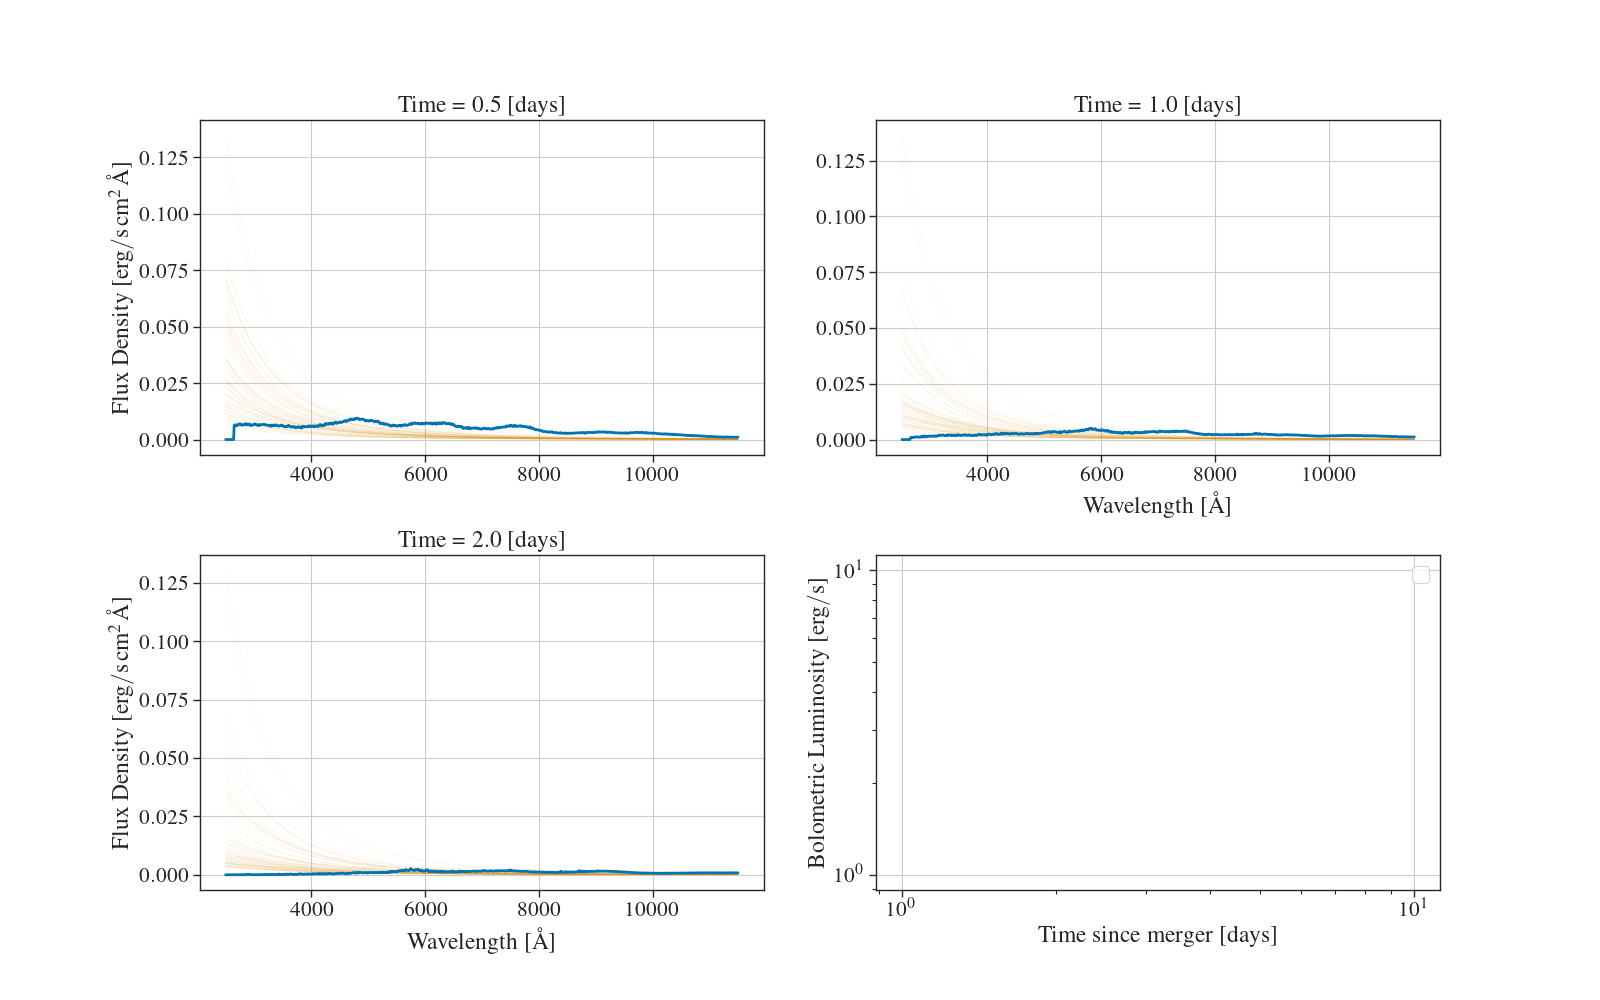

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-15.51609284369401
-14.498876876838025
-13.114851079911334


In [83]:
fig, axs = plt.subplots(2,2, figsize=(16,10))
subset = 100
gw170817_waves = gw_170817_wave[gw_170817_wave < 11500]
t1 = 60/day_in_s # start at a minimum time of 10 minutes
t2 = 20 # compute to one day past end of SuperNu data
ti_dat = np.linspace(t1, t2, 100)

for m1s, m2s, incl in zip(source_m1[:subset], source_m2[:subset], viewing_angle[:subset]):
    if m2s/m1s < 2.0/3:
        continue
    else:
        gw_samp_kn = saeev(
                m1=m1s,
                m2=m2s,
                theta_obs=incl,
                EOS="sfho",
                EOS_path="~/Documents/Project1_kNe/kne_modeling/eos_data/",
                kappa_grid_path="~/Documents/Project1_kNe/kne_modeling/korobkin_heating_rates/outputs/thresholded_uncertainties_20_opacity_df_020221.csv",
            )
        mej = gw_samp_kn.param10
        vej = gw_samp_kn.param8
        kappa = gw_samp_kn.param9
        Ye = gw_samp_kn.param6

        
        # compute the luminosity and temperature evolution
        ti, Li, Ti, Ri = calculate_saee_T_and_L(mej, vej, kappa, Ye, t1, t2)
        ti_days = ti / day_in_s
        # interpolate the model data to the SuperNu data times
        interpolator_L = interp1d(ti_days, Li)
        interpolator_T = interp1d(ti_days, Ti)
        # construct luminosity array for generating the SED
        luminosity = np.empty(shape=(len(ti_dat), 3))
        luminosity[:, 0] = ti_dat
        luminosity[:, 1] = interpolator_L(ti_dat)
        luminosity[:, 2] = interpolator_T(ti_dat)
        # compute the SED
        phase, wave, flux = sed_timeseries(luminosity, gw_170817_wave)

        ## Put data into model format so consistent between all compared models

        source2 = sncosmo.TimeSeriesSource(phase, wave, flux)
        SAEE_nHR = sncosmo.Model(source = source2)
        for t, a, i in [[0.5,(0,0), 8], [1.0,(0,1), 16], [2.0,(1,0), 24]]:
        # get spectral flux density from each model
            f_saee_nHR = SAEE_nHR.flux(t, gw170817_waves)
            axs[a].plot(gw170817_waves, f_saee_nHR, label='SAEE - $\kappa_{\mathrm{grey}}$', zorder=1, linewidth=0.25, alpha=0.15, color=circular[1])
for t, a, i in [[0.5,(0,0), 8], [1.0,(0,1), 16], [2.0,(1,0), 24]]:
    print(gw170817_model.bandmag('lsstg','ab', t))
    f_gw170817 = gw170817_model.flux(t, gw170817_waves)    
    axs[a].plot(gw170817_waves, f_gw170817, label='AT2017gfo DES model', zorder=100, linewidth=2)
    axs[a].set_title(r'Time = {} [days]'.format(t))
    axs[a].grid()
    axs[a].set_rasterization_zorder(99)
#axs[1,1].plot(times, lum_saee_nhr, label='SAEE - $\kappa_{\mathrm{grey}}$', linewidth=3)
#axs[1,1].plot(times, lum_gw170817, label='AT2017gfo DES model', linewidth=3)
axs[1,0].set_xlabel(r'Wavelength [$\mathrm{\mathring{A}}$]')
axs[0,1].set_xlabel(r'Wavelength [$\mathrm{\mathring{A}}$]')
axs[1,1].set_xlabel(r'Time since merger [days]')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[0,0].set_ylabel(r'Flux Density [$\mathrm{erg}/ \mathrm{s \, cm^2} \, \mathrm{\mathring{A}}$]')
axs[1,0].set_ylabel(r'Flux Density [$\mathrm{erg}/ \mathrm{s \, cm^2} \, \mathrm{\mathring{A}}$]')
axs[1,1].set_ylabel(r'Bolometric Luminosity [$\mathrm{erg}/ \mathrm{s}$]')       
axs[1,1].legend()
plt.subplots_adjust(wspace=0.2, 
                    hspace=0.3)
axs[1,1].grid()
axs[1,1].set_rasterization_zorder(99)
plt.savefig(figs_path + f'model_mismatch_GW170817_multiplot.pdf',bbox_inches='tight')
plt.show()